# 物联网数据分析

---
## 1. 批处理出图

原阳
商丘
泰安
深州
西平


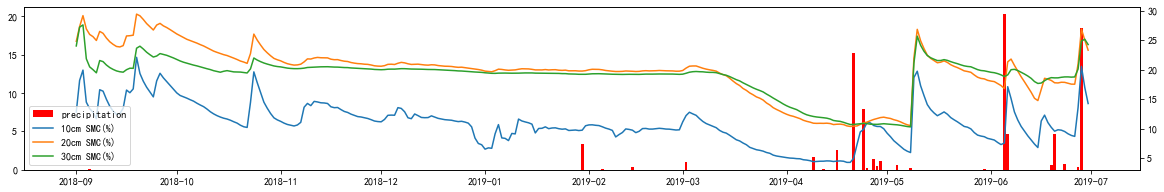

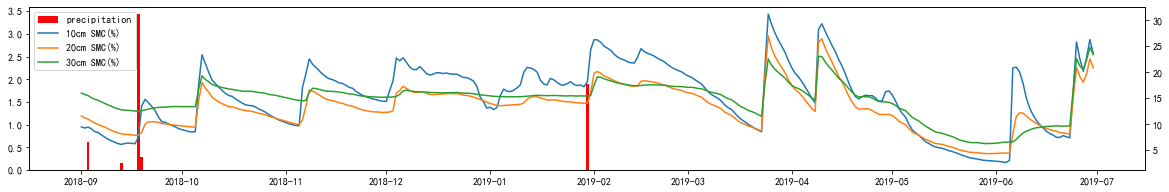

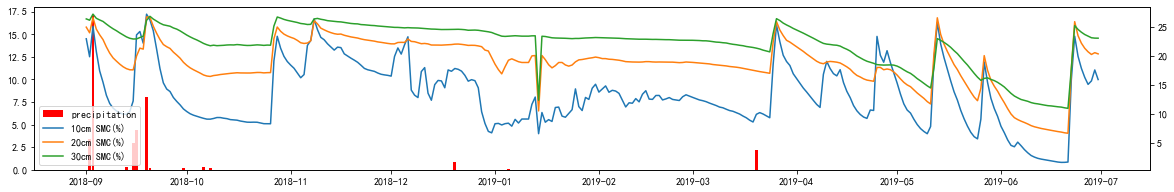

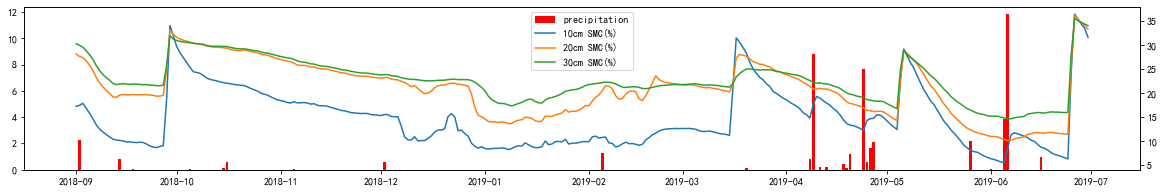

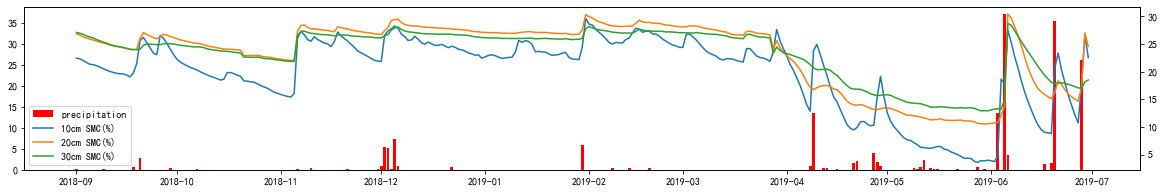

In [77]:
%matplotlib inline
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
from glob import glob
from osgeo import gdal
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
smc_dir = r'D:\wsy\Data\黄淮海干旱项目数据\物联网数据\csv\smc\\'
pre_dir = r'D:\wsy\Data\黄淮海干旱项目数据\物联网数据\csv\pre\\'
outpath = r'D:\wsy\Data\黄淮海干旱项目数据\物联网数据\\'
smc_list = glob(smc_dir+'*')
pre_list = glob(pre_dir+'*')

for i in range(len(smc_list)):
    #分别读入土壤水和降水序列
    smc_file = smc_list[i]
    pre_file = pre_list[i]
    cityname = os.path.basename(smc_file)[:2]
    print(cityname)
    outname = outpath + cityname + '土壤水分和降水时间序列图.png'
    df=pd.read_csv(smc_file,engine='python')
    df_pre = pd.read_csv(pre_file,engine='python')
    
    #设置时间区间，新建时间序列
    dates_list =  pd.date_range(start='9/01/2018', end='6/30/2019')
    dates_list =  pd.to_datetime(dates_list)
    
    #读入SMC的dataframe
    df = df.set_index(df.columns[0])
    df.index = df.index.map(pd.to_datetime)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    mean_data = df.groupby(['year','month','day'])['10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'].agg('mean')

    #读入Pre的dataframe
    df_pre = df_pre.set_index(df_pre.columns[0])
    df_pre.index = df_pre.index.map(pd.to_datetime)
    df_pre['year'] = df_pre.index.year
    df_pre['month'] = df_pre.index.month
    df_pre['day'] = df_pre.index.day
    df_add_pre = df_pre.groupby(['year','month','day'])['precipitation'].sum()
    
    #画图
    fig,ax = plt.subplots(figsize=(20,3))
    ln1 = ax.bar(dates_list,df_add_pre[(2018,9,1):(2019,6,30)],color='r')
    ax2 = ax.twinx()
    ln2, = ax2.plot(dates_list,mean_data['10cm SMC(%)'][(2018,9,1):(2019,6,30)])
    ln3, = ax2.plot(dates_list,mean_data['20cm SMC(%)'][(2018,9,1):(2019,6,30)])
    ln4, = ax2.plot(dates_list,mean_data['30cm SMC(%)'][(2018,9,1):(2019,6,30)])
    plt.legend(handles=[ln1,ln2,ln3,ln4], labels=['precipitation','10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'])
    plt.savefig(outname,dpi=300)

## 2. 批处理生成监测点邻近SIF的时间序列

In [1]:
%matplotlib inline
from L2_tools import *
from netCDF4 import Dataset
import numpy as np
from glob import glob
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from netCDF4 import Dataset
import math

from scipy import interpolate
from scipy.signal import savgol_filter

path  = r'D:\\wsy\\Data\\SIF\\TROPO\\ungridded_nc\\'
filelist = glob(path+'*.nc')
outpath = r'C:\Users\siyli\Desktop\sif_smc\\'
filelen= len(filelist)


In [2]:
'''
 根据经纬度提取图像上的像素值
'''
from osgeo import gdal
from osgeo import osr
import numpy as np

def get_file_info(in_file_path):
    '''
    根据tif路径，以只读的方式打开图像
    return：gdal数据集、地理空间坐标系、投影坐标系、栅格影像的大小相关信息
    '''
    #
    pca = None
    gcs = None
    shape = None
    #
    if in_file_path.endswith(".tif") or in_file_path.endswith(".TIF"):
        dataset = gdal.Open(in_file_path)
        pcs = osr.SpatialReference()
        pcs.ImportFromWkt(dataset.GetProjection())
        gcs = pcs.CloneGeogCS()
        extend = dataset.GetGeoTransform()
        shape = (dataset.RasterXSize,dataset.RasterYSize)
    else:
        raise("unsupported file format!")
    return dataset, gcs, pcs, extend, shape 

def lonlat_to_xy(gcs,pcs,lon,lat):
    '''
    经纬度坐标转换为投影坐标
    gcs: 地理空间坐标信息，由函数get_file_info()函数获取
    pcs: 投影坐标信息
    lon: 经度
    lat: 纬度
    return: 地理空间坐标对应的投影坐标
    '''
    #
    ct = osr.CoordinateTransformation(gcs,pcs)
    coordinates = ct.TransformPoint(lon,lat,0)
    #
    return coordinates[0],coordinates[1],coordinates[2]

def xy_to_lonlat(gcs,pcs,x,y):
    '''
    投影坐标转换为经纬度坐标
    gcs: 地理空间坐标信息，由函数get_file_info()函数获取
    pcs: 投影坐标信息
    x: 投影坐标x
    y: 投影坐标y
    return:投影坐标对应的地理空间坐标
    '''
    #
    ct = osr.CoordinatesTransformation(pcs,gcs)
    lon, lat, _ = ct.TransformPoint(x,y)
    #
    return lon,lat

def xy_to_rowcol(extend,x,y):
    '''
    根据GDAL六参数模型把给定的投影坐标转换为行列号
    extend: 图像的空间范围
    x: 投影坐标x
    y: 投影坐标y
    return: 投影坐标（x，y）对应的行列号（row，col）
    '''
    a = np.array([[extend[1],extend[2]],[extend[4],extend[5]]])
    b = np.array([x - extend[0], y- extend[3]])
    #
    row_col = np.linalg.solve(a,b) #使用numpy的linalg.solve进行二元一次方程的求解
    row = int(np.floor(row_col[1]))
    col = int(np.floor(row_col[0]))
    #
    return row,col 

def rowcol_to_xy(extend,row,col):
    '''
    图像坐标转换为投影坐标，将行列号转换为地理坐标或者投影坐标（根据具体数据的坐标系统转换）
    
    extend: 图像的空间范围
    row:  像元的行号
    col: 像元的列号
    return: 行列号（row，col）对应的投影坐标（x，y）
    '''
    #
    x = extend[0] + row * extend[1] + col * extend[2]
    y = extend[3] + row * extend[4] + col * extend[5]
    #
    return x, y

def get_value_by_coordinates(file_path, coordinates, coordinates_type = "lonlat"):
    '''
    直接根据图像图像坐标，或者根据GDAL六参数模型给定的投影、地理坐标系转换为图上坐标后，返回对应
    像元的像元值
    
    file_path: 文件路径
    coordinates: 两个元素的元组，行列号、投影坐标、或者地理空间坐标
    coordinates_type: "rowcol","xy","lonlat"
    return:指定坐标的像元值
    '''
    #
    dataset,gcs,pcs,extend,shape = get_file_info(file_path)
    img = dataset.GetRasterBand(1).ReadAsArray()
    value = None
    #
    if coordinates_type == "lonlat":
        x,y,_ = lonlat_to_xy(gcs,pcs,coordinates[0],coordinates[1])
        row,col = xy_to_rowcol(extend,x,y)
        #print("对应图像的行列号为：","  ",row,col)
        value = img[row,col]
    elif coordinates_type == "rowcol":
        value = img[coordinates[0],coordinates[1]]
    elif coordinates_type == "xy":
        row,col = xy_to_rowcol(extend,coordinates[0],coordinates[1])
        value = img[row,col]
    else:
        raise('''"coordinates_type": Wrong parameters input''')
    return value

In [3]:
#测试上述函数的功能
wheat_tif='C:/Users/siyli/Desktop/wheat_HHH.tif'
lat = [35.014712,34.531862,35.96824,37.900735,33.29542]
lon = [113.687952,115.71006,117.088713,115.706568,114.02001]
_,gcs,pcs,extend,_ = get_file_info(wheat_tif)
y = 37.8
x = 113.68
coordinates = list([x,y])
print(type(coordinates))
pixel_value = get_value_by_coordinates(wheat_tif,coordinates,coordinates_type = "lonlat")
xy = lonlat_to_xy(gcs,pcs,coordinates[0],coordinates[1])
print("坐标是：",coordinates,'\n',
      "经纬度坐标提取：",pixel_value,'\n',
      "投影坐标xy是：",xy,'\n',
     )


    
lat = [35.014712,34.531862,35.96824,37.900735,33.29542]
lon = [113.687952,115.71006,117.088713,115.706568,114.02001]
for i in range(0,5):
    y = lat[i]
    x = lon[i]
    coordinates = list([x,y])
    value = get_value_by_coordinates(wheat_tif,coordinates,coordinates_type = "lonlat")
    print(value)

<class 'list'>
坐标是： [113.68, 37.8] 
 经纬度坐标提取： 0 
 投影坐标xy是： (113.68, 37.8, 0.0) 

0
0
0
0
1


In [17]:
#%%time
#将定义的经纬度坐标作为中心点，窗口大小作为搜索范围，检索此范围内的sif数据，取均值作为某时间点的sif代表值
def sif_sequence(file,lat=35.013925,lon=113.694123,win=0.2,wheat_tif='C:/Users/siyli/Desktop/wheat_HHH.tif',method = "median"):   
    longitude = lon
    latitude = lat
    window = win
    latMin = latitude-window
    latMax = latitude+window
    lonMin = longitude-window
    lonMax = longitude+window
    sif_w = []
    lat_w = []
    lon_w = []
    N_sif = []
    index_wheat = []
    dataset,gcs,pcs,extend,shape = get_file_info(wheat_tif)#tif的基本信息
    img = dataset.GetRasterBand(1).ReadAsArray()
    value = None
    nc_day = Dataset(file)
    index_w = np.where((nc_day['lon'][:]>lonMin)&(nc_day['lon'][:]<lonMax)&(nc_day['lat'][:]>latMin)&(nc_day['lat'][:]<latMax))
    N_sif_w = len(nc_day['sif'][index_w])#落在此区域sif值个数
    #print(file+'______'+str(N_sif_w))
    lon_list = nc_day['lon'][index_w]
    lat_list = nc_day['lat'][index_w]
    sif_list = nc_day['sif'][index_w]
    
    #print(sif_list)
    ##遍历每一个sif值的经纬度，判断是否为冬小麦，若不是，从siflist里删除
    for i in range(0,N_sif_w):
        y = lat_list[i]
        x = lon_list[i]
        coordinates = list([x,y])
        a = np.array([[extend[1],extend[2]],[extend[4],extend[5]]])
        b = np.array([x - extend[0], y- extend[3]])
        #
        row_col = np.linalg.solve(a,b) #使用numpy的linalg.solve进行二元一次方程的求解
        row = int(np.floor(row_col[1]))
        col = int(np.floor(row_col[0]))
        value = img[row,col]
        index_wheat = np.append(index_wheat,value)
        if value !=1:
            sif_list[i]=0  
    
    #print(index_wheat)
    #把搜索窗口中没有sif值的日期，存储为nan，其余取均值
    #print(sif_list)
    if N_sif_w == 0:
        sif = np.nan
    else:
        #把小于0的sif值也变成0
        index_neg = np.where(sif_list <= 0)
        sif_list[index_neg] = 0
        sif_list = list(filter(lambda x:x!=0,sif_list)) # 去除0元素
        if method == "mean":
            sif = np.mean(sif_list)
        elif method == "median":
            sif = np.median(sif_list)
        else:
            raise('''"Method to calculate": Wrong parameters input''')
        
        if sif == 0:
            sif = np.nan
    #print(sif_list) 
    return sif,N_sif_w


In [5]:
file = r"D:\wsy\Data\SIF\TROPO\ungridded_nc\TROPO_SIF_2018-09-10_ungridded.nc"
sif,N_sif_w = sif_sequence(file)

[0.7683]
0


c:\python37\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\python37\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
def fillna_with_interpolation(data):
    idx_x = []
    idx_y = []
    for i,item in enumerate(data):
        if not math.isnan(item):
            idx_x.append(i)
            idx_y.append(item)
    data2 = data
    if 0 not in idx_x:
        idx_x.insert(0,0)
        idx_y.insert(0,idx_y[0])
    if len(data2)-1 not in idx_x:
        idx_x.append(len(data2)-1)
        idx_y.append(idx_y[-1])

    lin = interpolate.interp1d(idx_x, idx_y)

    for i in range(len(data2)):
        if math.isnan(data2[i]):
            data2[i] = lin(i)
    return data2

In [7]:
%%time
#原阳商丘泰安深州西平,分别将10cm，20cm，30cm的五个监测点的土壤水分按照上述顺序存入数组
import numpy as np
import pandas as pd
from datetime import datetime
dates =  pd.date_range(start='9/01/2018', end='6/30/2019')
lat = [35.014712,34.531862,35.96824,37.900735,33.29542]
lon = [113.687952,115.71006,117.088713,115.706568,114.02001]
name = ['Yuanyang','Shangqiu','Taian','Shenzhou','Xiping']

#分别将10cm，20cm，30cm的五个监测点的土壤水分按照上述顺序存入数组
smc_10 = np.zeros((303,5),dtype=float)
smc_20 = np.zeros((303,5),dtype=float)
smc_30 = np.zeros((303,5),dtype=float)
smc_dir = r'D:\wsy\Data\HHH_drought\物联网数据\csv\smc\\'
smc_list = glob(smc_dir+'*')
for i in range(len(smc_list)):
    print(i)
    smc_file = smc_list[i]
    df=pd.read_csv(smc_file,engine='python')  
    #读入SMC的dataframe
    df = df.set_index(df.columns[0])
    df.index = df.index.map(pd.to_datetime)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    mean_data = df.groupby(['year','month','day'])['10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'].agg('mean')
    smc_10[:,i] = mean_data['10cm SMC(%)'][(2018,9,1):(2019,6,30)]
    smc_20[:,i] = mean_data['20cm SMC(%)'][(2018,9,1):(2019,6,30)]
    smc_30[:,i] = mean_data['30cm SMC(%)'][(2018,9,1):(2019,6,30)]
print('完成！')

0
1
2
3
4
完成！
Wall time: 7.3 s


生成基于判断条件筛选sif数据生成序列的函数

Yuanyang  已完成！
Shangqiu  已完成！
Taian  已完成！
Shenzhou  已完成！
Xiping  已完成！
Yuanyang  已完成！
Shangqiu  已完成！
Taian  已完成！
Shenzhou  已完成！
Xiping  已完成！
Wall time: 12min 27s


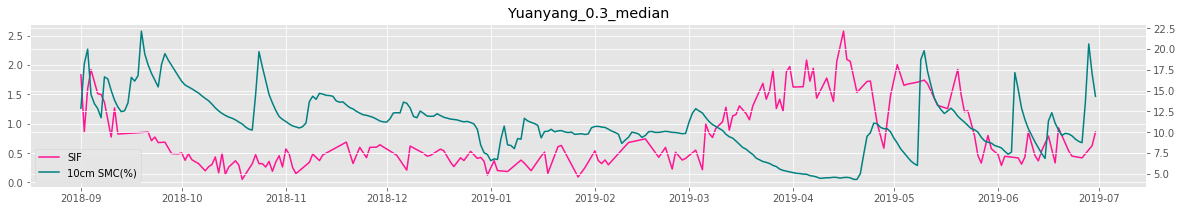

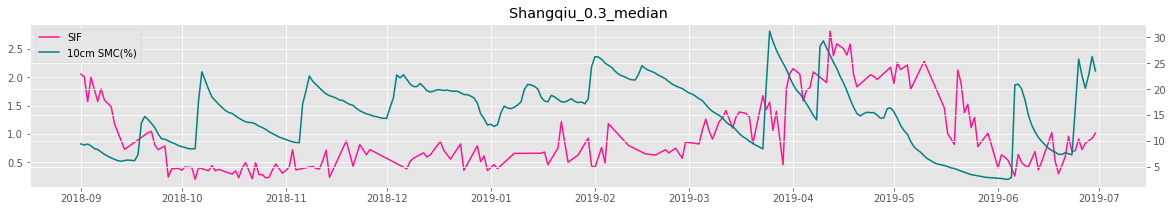

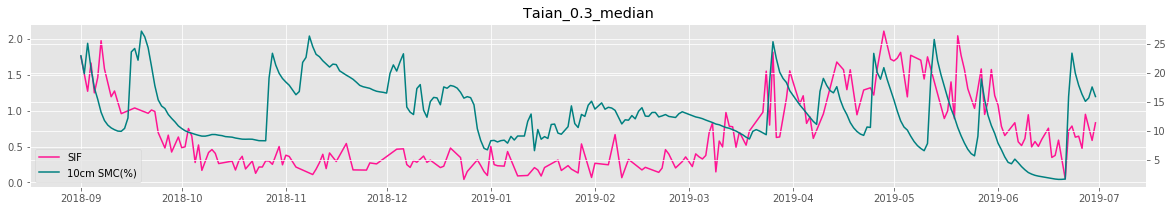

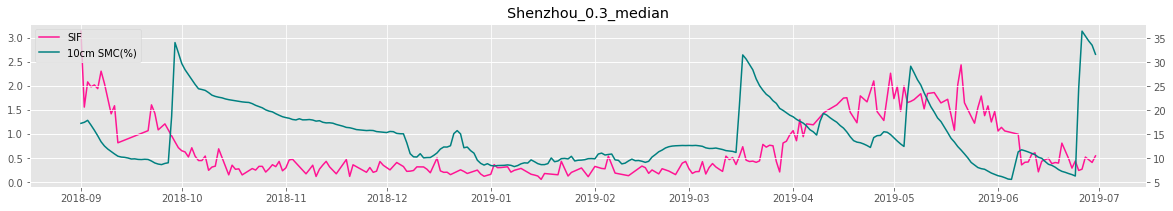

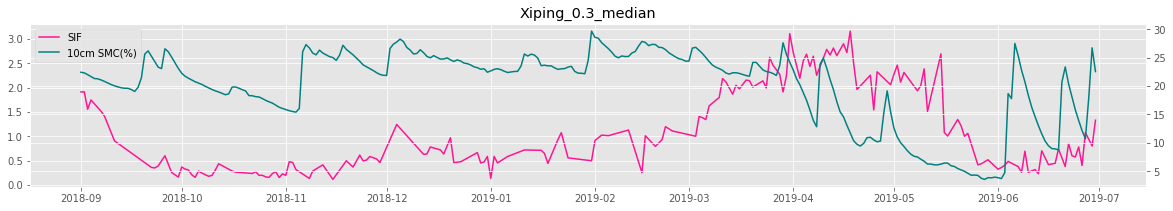

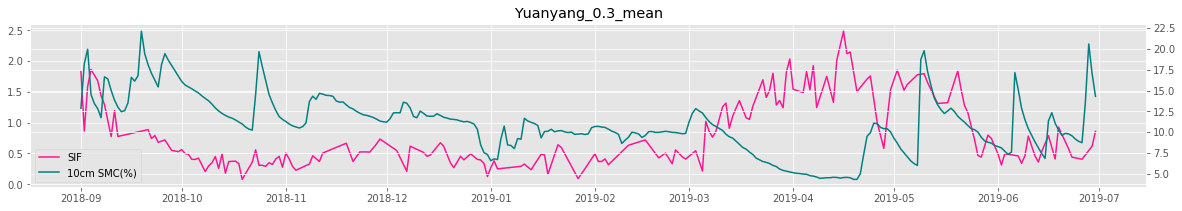

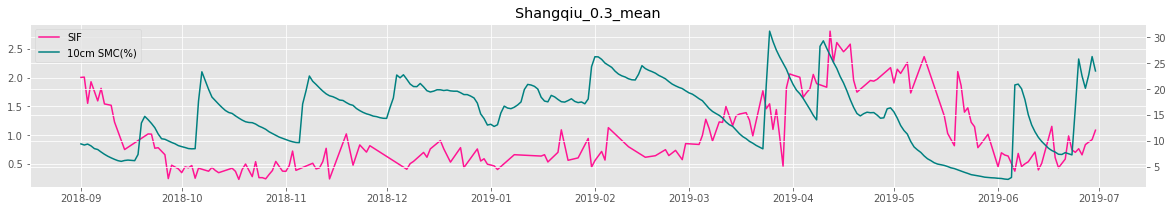

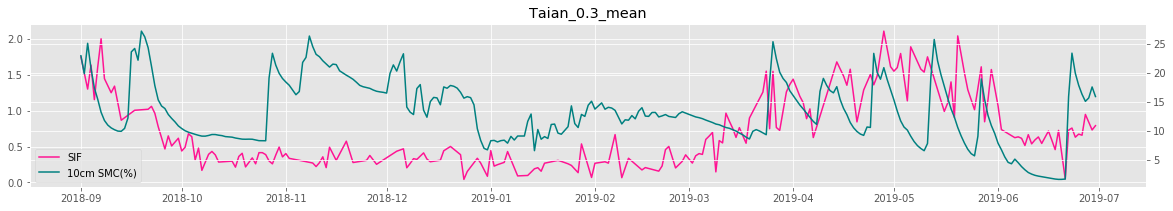

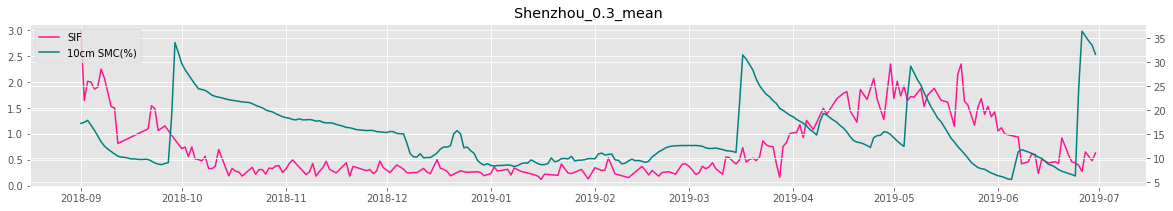

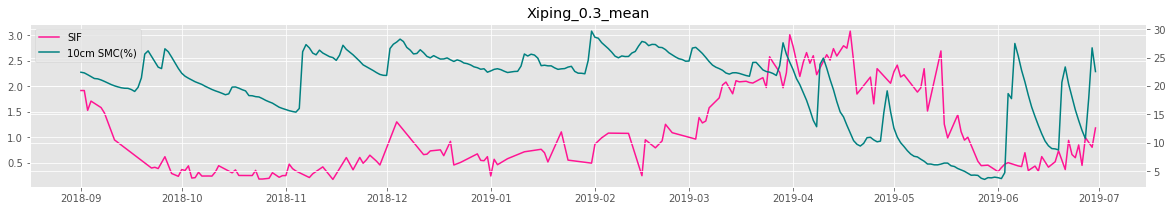

In [22]:
%%time
#测试得到条件筛选后的sif序列，sif返回的每天符合条件的sif均值，N_sif是符合条件的个数
outpath = r'C:\Users\siyli\Desktop\sif_smc\\'
for i in range(0,5):
    sif_w = []
    N_sif = []
    for file in filelist:
        sif,N_sif_w = sif_sequence(file,lat=lat[i],lon=lon[i],win=0.3,wheat_tif='C:/Users/siyli/Desktop/wheat_HHH.tif')
        sif_w = np.append(sif_w,sif)
        N_sif = np.append(N_sif,N_sif_w)#得到每个监测点周围符合条件的sif个数
    #print(len(N_sif),len(N_sif[np.where(N_sif > 0)]))
    sif_w_fn = fillna_with_interpolation(sif_w)#插补有缺值的sif序列
    #plot五个监测点的土壤水和sif序列对比图
    fig,ax = plt.subplots(figsize=(20,3))
    ln1, = ax.plot(dates,sif_w_fn,color='deeppink')
    ax2 = ax.twinx()
    ln2,= ax2.plot(dates,smc_10[:,i],color='teal')
    plt.legend(handles=[ln1,ln2], labels=['SIF','10cm SMC(%)'])
    plt.title(name[i]+'_0.3_median')
    plt.savefig(outpath+name[i]+'0.3_median.png',dpi=300)
    print(name[i]+'  已完成！')
    #break

    
for i in range(0,5):
    sif_w = []
    N_sif = []
    for file in filelist:
        sif,N_sif_w = sif_sequence(file,lat=lat[i],lon=lon[i],win=0.3,wheat_tif='C:/Users/siyli/Desktop/wheat_HHH.tif',method = 'mean')
        sif_w = np.append(sif_w,sif)
        N_sif = np.append(N_sif,N_sif_w)#得到每个监测点周围符合条件的sif个数
    #print(len(N_sif),len(N_sif[np.where(N_sif > 0)]))
    sif_w_fn = fillna_with_interpolation(sif_w)#插补有缺值的sif序列
    #plot五个监测点的土壤水和sif序列对比图
    fig,ax = plt.subplots(figsize=(20,3))
    ln1, = ax.plot(dates,sif_w_fn,color='deeppink')
    ax2 = ax.twinx()
    ln2,= ax2.plot(dates,smc_10[:,i],color='teal')
    plt.legend(handles=[ln1,ln2], labels=['SIF','10cm SMC(%)'])
    plt.title(name[i]+'_0.3_mean')
    plt.savefig(outpath+name[i]+'0.3_mean.png',dpi=300)
    print(name[i]+'  已完成！')
   # break

---
## 3. 实验过程

### 3.1 根据物联网数据构建土壤水分和降水时间序列
将物联网监测的逐小时土壤水分和降水统计为日均值和日累计值，同时期对比分析土壤水分升高的原因

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
from glob import glob
from osgeo import gdal
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df=pd.read_csv('D:/wsy/Data/黄淮海干旱项目数据/物联网数据/csv/原阳smc.csv',engine='python')
#data = df.head(50)
# for i in range(0,len(df.columns)):
#     print(df[df.columns[i]].dtypes)
#print(df.columns)
x = df['Acquisition time(c)']
x=pd.to_datetime(x)
y1=df['10cm SMC(%)']
y2=df['20cm SMC(%)']
y3=df['30cm SMC(%)']
y4=df['40cm SMC(%)']
#fig,ax = plt.subplots(1,1,figsize=(20,5))
#df.plot(x='Acquisition time(c)',y='20cm SMC(%)',kind='line',ax=ax)
fig = plt.figure(figsize=(20,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.legend()
plt.savefig('C:\\Users\\siyli\\Desktop\\smc_yuanyang.png')

FileNotFoundError: [Errno 2] No such file or directory: 'D:/wsy/Data/黄淮海干旱项目数据/物联网数据/csv/原阳smc.csv'

303 303


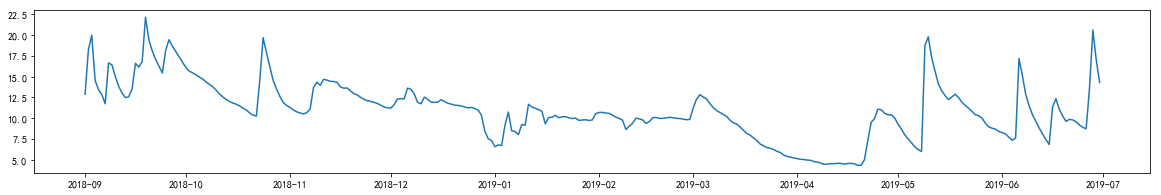

In [3]:
df = df.set_index('Acquisition time(c)')
df.index = df.index.map(pd.to_datetime)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
mean_data = df.groupby(['year','month','day'])['10cm SMC(%)','20cm SMC(%)','30cm SMC(%)'].agg('mean')
dates_list =  pd.date_range(start='9/01/2018', end='6/30/2019')
print(len(dates_list),len(mean_data['10cm SMC(%)'][:-31]))
plt.figure(figsize=(20,3))
plt.plot(dates_list,mean_data['10cm SMC(%)'][:-31])

<BarContainer object of 303 artists>

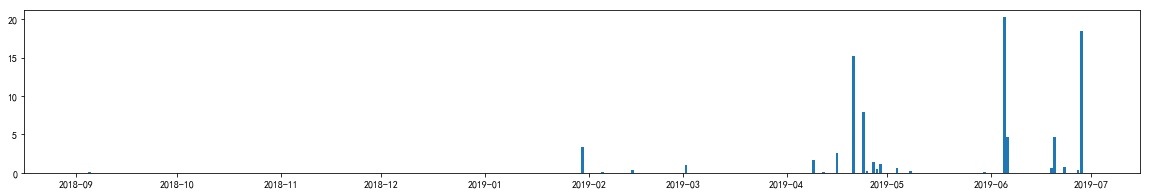

In [4]:
df_pre = pd.read_csv('D:/wsy/Data/黄淮海干旱项目数据/物联网数据/csv/原阳pre.csv',engine='python')
df_pre = df_pre.set_index('Acquisition time')
df_pre.index = df_pre.index.map(pd.to_datetime)
df_pre['year'] = df_pre.index.year
df_pre['month'] = df_pre.index.month
df_pre['day'] = df_pre.index.day
df_add_pre = df_pre.groupby(['year','month','day'])['precipitation','External input voltage'].sum()
plt.figure(figsize=(20,3))
plt.bar(dates_list,df_add_pre['precipitation'][:-31])

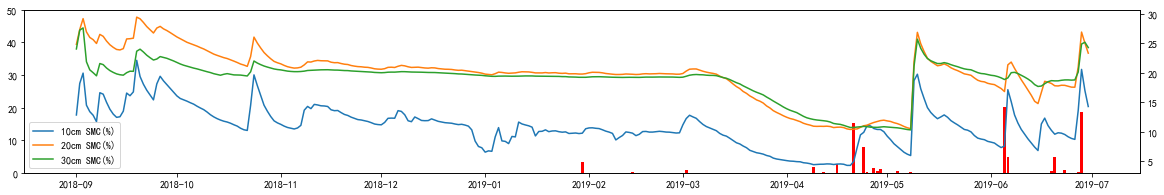

In [7]:
fig,ax = plt.subplots(figsize=(20,3))
ax.bar(dates_list,df_add_pre['precipitation'][:-31],color='r')
plt.ylim(0,50)
ax2 = ax.twinx()
ax2.plot(dates_list,mean_data['10cm SMC(%)'][:-31])
ax2.plot(dates_list,mean_data['20cm SMC(%)'][:-31])
ax2.plot(dates_list,mean_data['30cm SMC(%)'][:-31])
plt.legend()

---
### 3.2 基于栅格化的dcSIF数据集，进行逐像素SIF时间序列提取
输出定义的经纬度范围内，每个0.1°×0.1°像素的sif时间序列，以及线性插值和sg滤波后的时间序列示意图
- 河南原阳的监测点坐标为(35.013925,113.694123)，在 35.1- 34.9，113.6-113.8的0.2°×0.2°范围内，逐像素统计0.1°分辨率的时间序列sif栅格影像(dcSIF均值)
- 将时间序列数据进行线性插值，在没有数据的无效值时间点前向后检索有效值时期进行线性插值
- S-G滤波插值后的时间序列曲线

In [8]:
from netCDF4 import Dataset
import numpy as np
import sys
import xarray as xr
from osgeo import osr,ogr,gdal
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
from glob import glob 
import os 
import math 
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.signal import savgol_filter
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from datetime import datetime

dates = np.arange('2018-09-01', '2019-07-01', dtype='datetime64[1D]').astype(datetime)


def fillna_with_interpolation(data):
    idx_x = []
    idx_y = []
    for i,item in enumerate(data):
        if not math.isnan(item):
            idx_x.append(i)
            idx_y.append(item)
    data2 = data
    if 0 not in idx_x:
        idx_x.insert(0,0)
        idx_y.insert(0,idx_y[0])
    if len(data2)-1 not in idx_x:
        idx_x.append(len(data2)-1)
        idx_y.append(idx_y[-1])

    lin = interpolate.interp1d(idx_x, idx_y)

    for i in range(len(data2)):
        if math.isnan(data2[i]):
            data2[i] = lin(i)
    return data2


tiff_path = 'D:/wsy/Data/SIF/TROPO/tiff/0.1/dcSIF/MEAN/'#将0.1°分辨率的叶绿素荧光tiff文件读入到array数组中
filelist = glob(tiff_path+'*.tif')
filelen = len(filelist)
tif=gdal.Open(filelist[0])
width = tif.RasterXSize
height = tif.RasterYSize
array = np.zeros((filelen,height,width),dtype=np.float64)
i = 0
for file in filelist:
    #时间序列的SIF数组
    dataset = gdal.Open(file)
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    data = dataset.ReadAsArray(0,0,width,height)
    array[i,:,:]=data
    i+=1

lat1 = 35.1
lat2 = 34.9
lon1 = 113.6
lon2 = 113.8

height1 = round((43.0-lat1)*10)
height2 = round((43.0-lat2)*10)
width1 = round((lon1-110.0)*10)
width2 = round((lon2-110.0)*10)
#print(height1,height2,width1,width2)

df_sif = pd.DataFrame()
df_smc = pd.DataFrame()
dates = pd.date_range(start='9/01/2018', end='6/30/2019')
dates = pd.to_datetime(dates)
#dates = np.arange('2018-09-01', '2019-07-01', dtype='datetime64[1D]').astype(datetime)
N = len(dates)
XT_sif = array[:,height1:height2,width1:width2]
height = height2-height1
width = width2-width1
print(height1,width1)

for h in range(0,height):
    for w in range(0,width):
        x = array[:,height1+h,width1+w]#每个像素的时间序列
        x_min = np.min(x)
        length = len(dates)
        index = np.where(x == -99)
        dates_nan = dates[index]
        nan_length = len(dates_nan)# 无效时间区间长度
        x[np.where(x == -99)] = np.nan
        
        
        plt.figure(figsize = (45,10))
        ax=plt.subplot(311)
        ax.scatter(dates,x,c='b')
        ax_nan=np.zeros(nan_length)+x_min
        ax.scatter(dates_nan,ax_nan,c='r',marker = 'x')
        plt.ylabel('原始的SIF时间序列')
        monthsLoc = mpl.dates.MonthLocator()
        monthsFmt = mpl.dates.DateFormatter("%Y-%m-%d") #%Y %b 为年月
        ax.xaxis.set_major_locator(monthsLoc)
        ax.xaxis.set_major_formatter(monthsFmt)
        
        
        ax2 = plt.subplot(312)
        xx = fillna_with_interpolation(x)#插值NAN值
        #ax2.plot(dates,xx,c='b',marker = '*',markerfacecolor='r',markeredgecolor='r')
        ax2.plot(dates,xx,c='b',marker = 'o')
        plt.ylabel('插值后的SIF时间序列')
        ax2.xaxis.set_major_locator(monthsLoc)
        ax2.xaxis.set_major_formatter(monthsFmt)
        

        ax3 = plt.subplot(313)
        yy = savgol_filter(xx,7,2)
        ax3.plot(dates,xx,'b',linestyle='--')
        ax3.plot(dates,yy,'r')
        lat = 43-(height1+h)*0.1
        lon = 110+(width1+w)*0.1
        plt.ylabel(str(lat)+' '+str(lon)+' 滤波后的时间序列')
        ax3.xaxis.set_major_locator(monthsLoc)
        ax3.xaxis.set_major_formatter(monthsFmt)
        outname = 'sif_yuanyang_'+str(lat)+'_'+str(lon)+'.png'
        plt.savefig('C:\\Users\\siyli\\Desktop\\'+outname,dpi=300.)
        #break
    #break

79 36


---
### 3.3 基于未栅格化数据，以物联网监测点为中心进行信号筛选和数据重建
将距离物联网监测点最近的footprint存成时间序列，排除非冬小麦信号

In [12]:
%matplotlib inline
from L2_tools import *
from netCDF4 import Dataset
import numpy as np

import xarray as xr
from glob import glob
from osgeo import gdal
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from netCDF4 import Dataset

import math
from scipy import interpolate
from scipy.signal import savgol_filter

def fillna_with_interpolation(data):
    idx_x = []
    idx_y = []
    for i,item in enumerate(data):
        if not math.isnan(item):
            idx_x.append(i)
            idx_y.append(item)
    data2 = data
    if 0 not in idx_x:
        idx_x.insert(0,0)
        idx_y.insert(0,idx_y[0])
    if len(data2)-1 not in idx_x:
        idx_x.append(len(data2)-1)
        idx_y.append(idx_y[-1])

    lin = interpolate.interp1d(idx_x, idx_y)

    for i in range(len(data2)):
        if math.isnan(data2[i]):
            data2[i] = lin(i)
    return data2

path  = 'D:\\wsy\\Data\\SIF\\TROPO\\ungridded_nc\\'
filelist = glob(path+'*.nc')
outpath = ''
filelen= len(filelist)


以下是不进行筛选直接将满足空间范围的sif进行取平均

In [11]:
%%time
#将定义的经纬度坐标作为中心点，窗口大小作为搜索范围，检索此范围内的sif数据，取均值作为某时间点的sif代表值
longitude = 113.694123
latitude = 35.013925
window = 0.2
latMin = latitude-window
latMax = latitude+window
lonMin = longitude-window
lonMax = longitude+window
sif_w = []
lat_w = []
lon_w = []
N_sif = []
for file in filelist:
    nc_day = Dataset(file)
    index_w = np.where((nc_day['lon'][:]>lonMin)&(nc_day['lon'][:]<lonMax)&(nc_day['lat'][:]>latMin)&(nc_day['lat'][:]<latMax))
    N_sif_w = len(nc_day['sif'][index_w])
    #print(file+'______'+str(N_sif_w))
    if N_sif_w == 0:
        sif = np.nan
    else:
        sif = np.mean(nc_day['sif'][index_w])
    sif_w = np.append(sif_w,sif)
    N_sif = np.append(N_sif,N_sif_w)


#print(nc.variables.keys())

Wall time: 1min 4s


得到时间序列SIF，进行线性插补

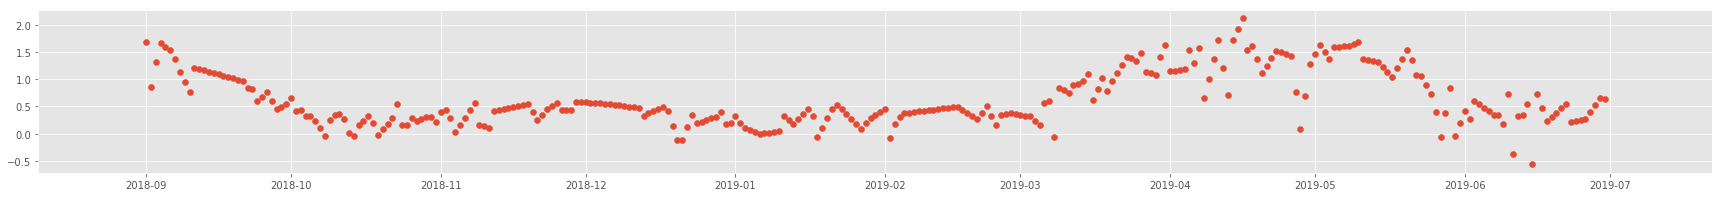

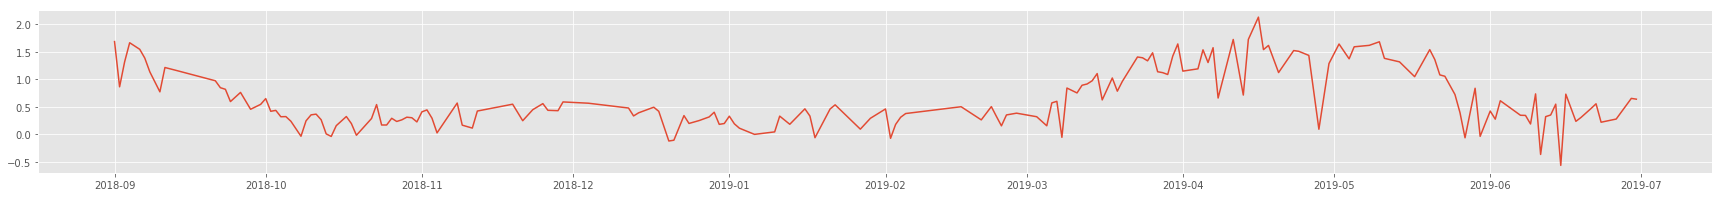

In [12]:
from datetime import datetime

dates = np.arange('2018-09-01', '2019-07-01', dtype='datetime64[1D]').astype(datetime)
sif_nan = sif_w
sif_w_fn = fillna_with_interpolation(sif_w)

plt.figure(figsize=(30,3))
plt.scatter(dates,sif_nan)

plt.figure(figsize=(30,3))
plt.plot(dates,sif_w_fn)
# axes[1].plot(dates,lat_far)
# axes[2].plot(dates,lon_far)

据判断条件筛选sif数据，取均值作为时间点监测点附近的sif均值

In [13]:
%%time
#将定义的经纬度坐标作为中心点，窗口大小作为搜索范围，检索此范围内的sif数据，
#根据判断条件筛选sif数据，取均值作为时间点监测点附近的sif均值
##筛选条件为：1.sif值的中心点坐标判断其是否在冬小麦分布区域，2.sif值是否大于0
longitude = 113.694123
latitude = 35.013925
window = 0.1
latMin = latitude-window
latMax = latitude+window
lonMin = longitude-window
lonMax = longitude+window
sif_w = []
lat_w = []
lon_w = []
N_sif = []
#读入冬小麦分布数据
gdal.AllRegister()
ds = gdal.Open('C:/Users/siyli/Desktop/wheat_HHH.tif')
rows = ds.RasterYSize
cols = ds.RasterXSize
transform = ds.GetGeoTransform()
xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = transform[5]

for file in filelist:
    nc_day = Dataset(file)
    index_w = np.where((nc_day['lon'][:]>lonMin)&(nc_day['lon'][:]<lonMax)&(nc_day['lat'][:]>latMin)&(nc_day['lat'][:]<latMax))
    N_sif_w = len(nc_day['sif'][index_w])#落在此区域sif值个数
    #print(file+'______'+str(N_sif_w))
    lon_list = nc_day['lon'][index_w]
    lat_list = nc_day['lat'][index_w]
    sif_list = nc_day['sif'][index_w]
    #print(sif_list)
    ##遍历每一个sif值的经纬度，判断是否为冬小麦，若不是，从siflist里删除
    for i in range(0,N_sif_w):
        y = lat_list[i]
        x = lon_list[i]
        xOffset = int((x-xOrigin)/pixelWidth)
        yOffset = int((y-yOrigin)/pixelHeight)
        band = ds.GetRasterBand(1)
        data = band.ReadAsArray(xOffset, yOffset,1,1)
        value = data[0,0]
        if value !=1:
            sif_list[i]=0  
    #把搜索窗口中没有sif值的日期，存储为nan，其余取均值
    #print(sif_list)
    if N_sif_w == 0:
        sif = np.nan
    else:
        #把小于0的sif值也变成0
        index_neg = np.where(sif_list <= 0)
        sif_list[index_neg] = 0
        sif = np.mean(sif_list)
        if sif == 0:
            sif = np.nan
    #print(sif_list)
    sif_w = np.append(sif_w,sif)
    N_sif = np.append(N_sif,N_sif_w)
    #break

Wall time: 1min 34s


得到时间序列SIF，进行线性插补

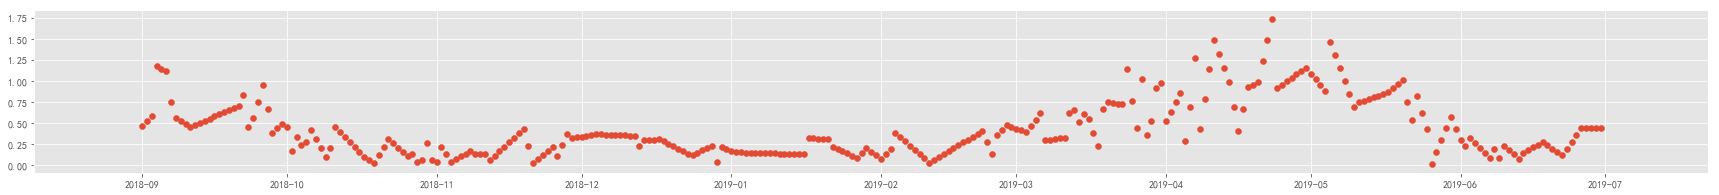

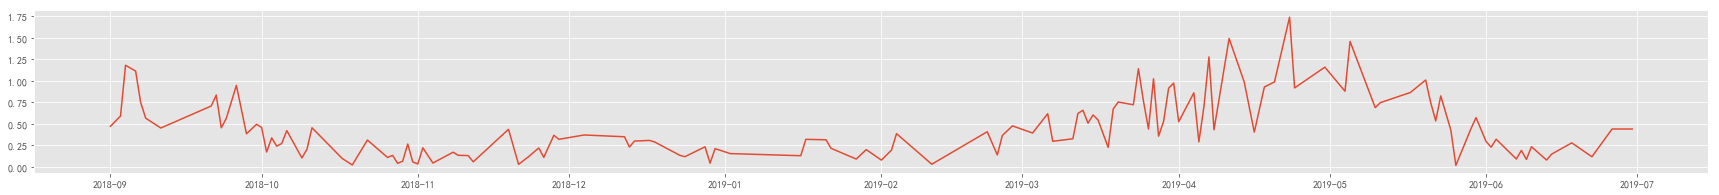

In [14]:
from datetime import datetime

dates = np.arange('2018-09-01', '2019-07-01', dtype='datetime64[1D]').astype(datetime)
sif_w_fn = fillna_with_interpolation(sif_w)
plt.figure(figsize=(30,3))
plt.scatter(dates,sif_w)
plt.figure(figsize=(30,3))
plt.plot(dates,sif_w_fn)

对比分析同时期土壤水分和sif变化

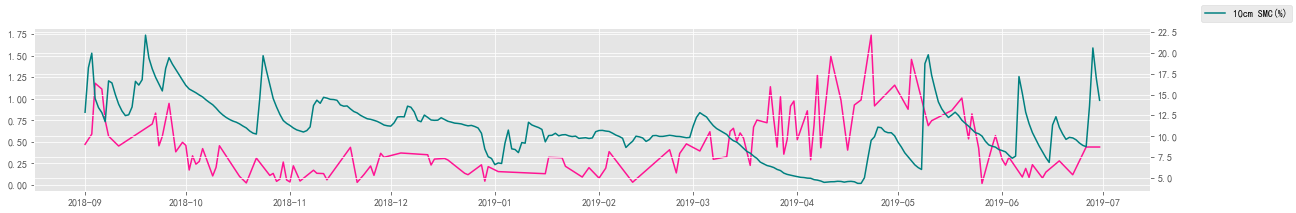

In [23]:
#将土壤水分和sif同时显示对比分析
fig,ax = plt.subplots(figsize=(20,3))
ax.plot(dates_list,sif_w_fn,color='deeppink')
ax2 = ax.twinx()
ax2.plot(dates_list,mean_data['10cm SMC(%)'][:-31],color='teal')
#ax2.plot(dates_list,mean_data['20cm SMC(%)'][:-31],color='cyan')
#ax2.plot(dates_list,mean_data['30cm SMC(%)'][:-31])
fig.legend()